In [ ]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

from tqdm import tqdm
from torchinfo import summary
from torch.utils.tensorboard import SummaryWriter

In [ ]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("using mps")
else:
    device = torch.device("cpu")
    print("using cpu")

using mps


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.2860,), (0.3530,))]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

test_dataset = datasets.FashionMNIST(
    root="./data", train=False, download=True, transform=transform
)

In [ ]:
batch_size = 128

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

### EDA

In [ ]:
len(train_dataset), len(test_dataset)

(60000, 10000)

In [ ]:
set_train = set(train_dataset.classes)
set_test = set(test_dataset.classes)

set_train == set_test

True

In [ ]:
def get_class_counts(dataset):
    labels = (
        dataset.targets.numpy()
        if hasattr(dataset.targets, "numpy")
        else np.array(dataset.targets)
    )
    return np.bincount(labels, minlength=len(dataset.classes))

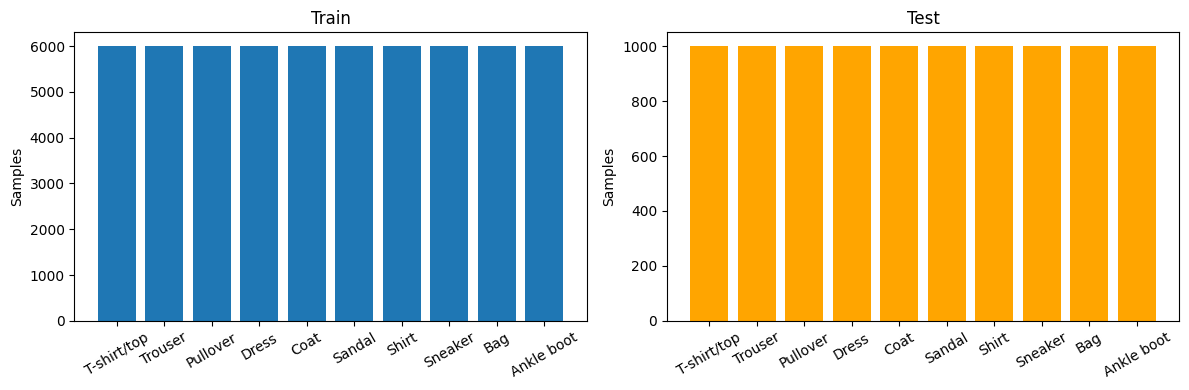

In [ ]:
train_counts = get_class_counts(train_dataset)
test_counts = get_class_counts(test_dataset)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(train_dataset.classes, train_counts)
axes[0].set_title("Train")
axes[0].set_ylabel("Samples")
axes[0].tick_params(axis="x", rotation=30)

axes[1].bar(test_dataset.classes, test_counts, color="orange")
axes[1].set_title("Test")
axes[1].set_ylabel("Samples")
axes[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

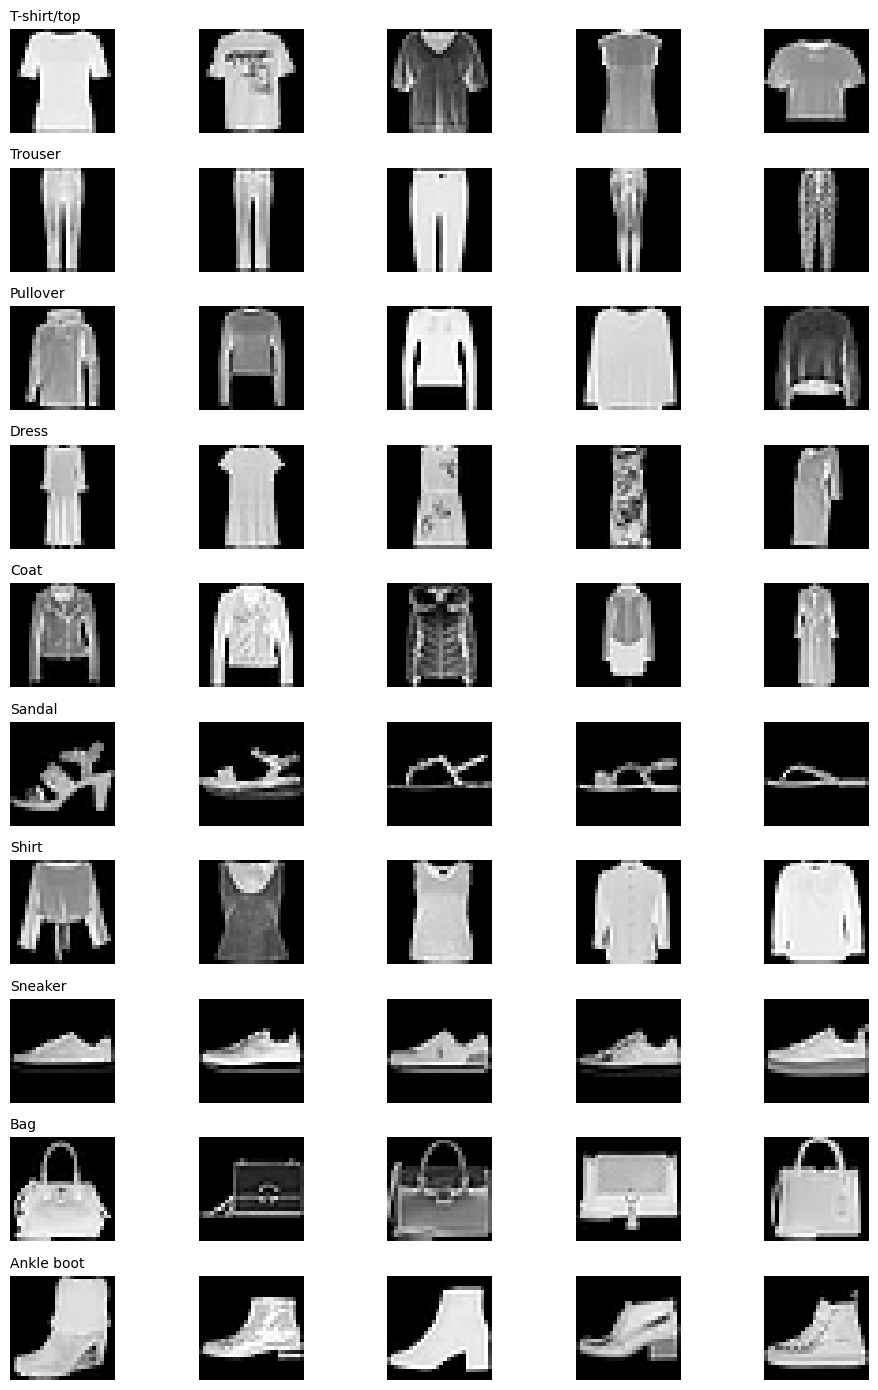

In [ ]:
n_classes = 10
n_per_class = 5

fig, axes = plt.subplots(n_classes, n_per_class, figsize=(10, 14))

for class_id in range(n_classes):
    idxs = (train_dataset.targets == class_id).nonzero(as_tuple=True)[0]
    # random 5 samples
    chosen = idxs[torch.randperm(len(idxs))[:n_per_class]]

    for j, idx in enumerate(chosen):
        # img is Tensor [1,H,W] because of ToTensor
        img, label = train_dataset[idx]
        axes[class_id, j].imshow(img.squeeze(0), cmap="gray")
        axes[class_id, j].axis("off")

        if j == 0:
            axes[class_id, j].set_title(
                train_dataset.classes[class_id], loc="left", fontsize=10
            )

plt.tight_layout()
plt.show()

#### Augmented

In [ ]:
augment_transform = transforms.Compose(
    [
        transforms.RandomAffine(
            degrees=10, translate=(0.05, 0.05), scale=(0.9, 1.1), shear=5
        ),
        transforms.RandomHorizontalFlip(p=0.2),
        transforms.ToTensor(),
        transforms.Normalize((0.2860,), (0.3530,)),
        transforms.RandomErasing(p=0.1, scale=(0.02, 0.1)),
    ]
)

train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=transform
)

In [ ]:
batch_size = 128

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

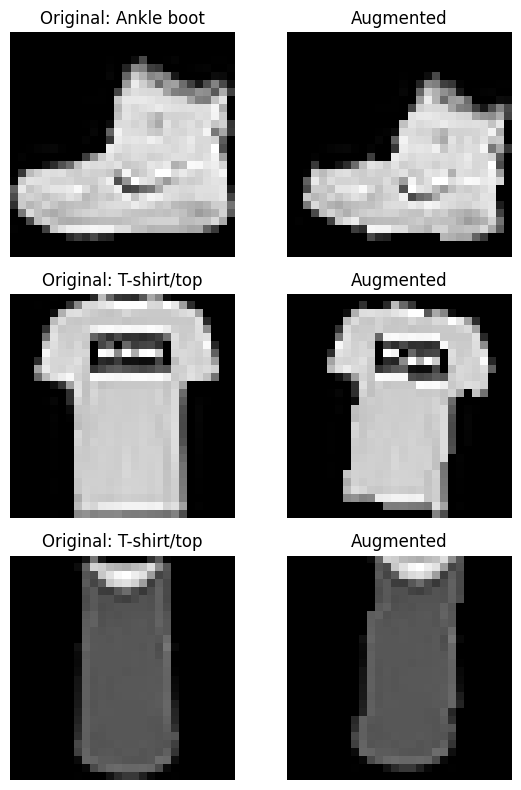

In [ ]:
fig, axes = plt.subplots(3, 2, figsize=(6, 8))

for i in range(3):
    # take raw PIL image + label
    pil_img, label = train_dataset.data[i], train_dataset.targets[i]
    pil_img = transforms.ToPILImage()(pil_img)

    orig = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))]
    )(pil_img)

    aug = augment_transform(pil_img)

    axes[i, 0].imshow(orig.squeeze(0), cmap="gray")
    axes[i, 0].set_title(f"Original: {train_dataset.classes[label]}")
    axes[i, 0].axis("off")

    axes[i, 1].imshow(aug.squeeze(0), cmap="gray")
    axes[i, 1].set_title("Augmented")
    axes[i, 1].axis("off")

plt.tight_layout()
plt.show()

### Train / Validation Split

In [ ]:
base_train_dataset = datasets.FashionMNIST(
    root="./data", train=True, download=True, transform=None
)

targets = base_train_dataset.targets.numpy()
indices = list(range(len(base_train_dataset)))

train_idx, val_idx = train_test_split(
    indices, test_size=0.2, stratify=targets, random_state=555
)

train_subset = Subset(base_train_dataset, train_idx)
val_subset = Subset(base_train_dataset, val_idx)

In [ ]:
def get_class_counts_from_subset(subset):
    base = subset.dataset
    labels = base.targets.numpy()[subset.indices]
    return np.bincount(labels, minlength=len(base.classes))

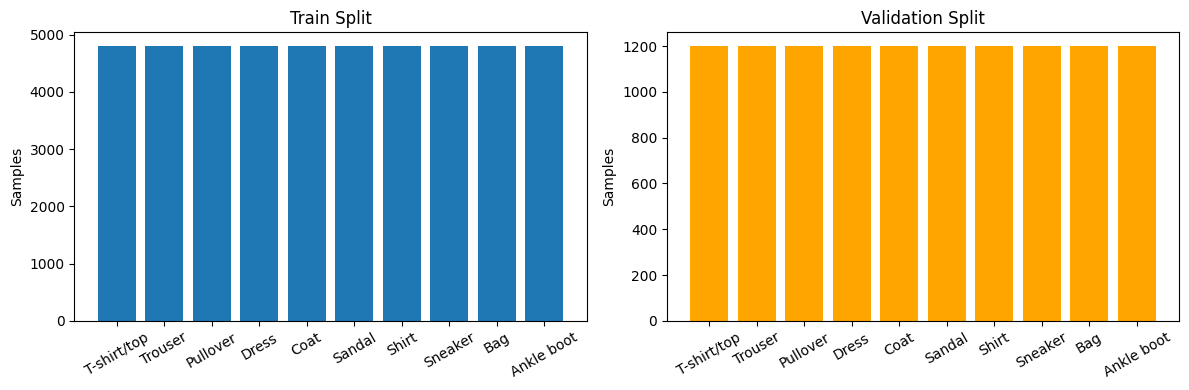

In [ ]:
train_counts = get_class_counts_from_subset(train_subset)
val_counts = get_class_counts_from_subset(val_subset)

class_names = train_subset.dataset.classes

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(class_names, train_counts)
axes[0].set_title("Train Split")
axes[0].set_ylabel("Samples")
axes[0].tick_params(axis="x", rotation=30)

axes[1].bar(class_names, val_counts, color="orange")
axes[1].set_title("Validation Split")
axes[1].set_ylabel("Samples")
axes[1].tick_params(axis="x", rotation=30)

plt.tight_layout()
plt.show()

In [ ]:
class TransformWrapper:
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, label = self.subset[idx]
        return self.transform(img), label


train_dataset = TransformWrapper(train_subset, augment_transform)
val_dataset = TransformWrapper(val_subset, transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            bs = labels.size(0)
            total_loss += loss.item() * bs

            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += bs

    avg_loss = total_loss / total
    accuracy = correct / total

    return avg_loss, accuracy

In [ ]:
def plot_train_val_curves(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    axes[0].plot(epochs, train_losses, color="blue", label="Train")
    axes[0].plot(epochs, val_losses, color="orange", label="Validation")
    axes[0].set_title("Loss")
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")
    axes[0].grid(True, linestyle="--", alpha=0.4)
    axes[0].legend()

    # Accuracy
    axes[1].plot(epochs, train_accs, color="blue", label="Train")
    axes[1].plot(epochs, val_accs, color="orange", label="Validation")
    axes[1].set_title("Accuracy")
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")
    axes[1].grid(True, linestyle="--", alpha=0.4)
    axes[1].legend()

    plt.tight_layout()
    plt.show()

### Linear Model

In [118]:
class MLPNet(nn.Module):
    def __init__(self, use_batchnorm=True, use_dropout=True):
        super().__init__()

        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout

        self.fc1 = nn.Linear(28 * 28, out_features=512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

        if self.use_batchnorm:
            self.bn1 = nn.BatchNorm1d(512)
            self.bn2 = nn.BatchNorm1d(256)

        if self.use_dropout:
            self.drop1 = nn.Dropout(0.4)
            self.drop2 = nn.Dropout(0.3)

        self.act = nn.ReLU()

    def forward(self, x):
        # collapse to (batch, all-pixels)
        x = x.view(x.size(0), -1)

        x = self.fc1(x)
        if self.use_batchnorm:
            x = self.bn1(x)
        x = self.act(x)
        if self.use_dropout:
            x = self.drop1(x)

        x = self.fc2(x)
        if self.use_batchnorm:
            x = self.bn2(x)
        x = self.act(x)
        if self.use_dropout:
            x = self.drop2(x)

        x = self.fc3(x)
        return x

Hyperparams

In [119]:
learning_rate = 0.001
epochs = 30

In [120]:
mlp_model = MLPNet(True, True).to(device)
optimizer = torch.optim.AdamW(mlp_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [121]:
writer = SummaryWriter(log_dir="linear_logs/mlp_aug1_bn1_do1")

In [122]:
summary(mlp_model)

Layer (type:depth-idx)                   Param #
MLPNet                                   --
├─Linear: 1-1                            401,920
├─Linear: 1-2                            131,328
├─Linear: 1-3                            2,570
├─BatchNorm1d: 1-4                       1,024
├─BatchNorm1d: 1-5                       512
├─Dropout: 1-6                           --
├─Dropout: 1-7                           --
├─ReLU: 1-8                              --
Total params: 537,354
Trainable params: 537,354
Non-trainable params: 0

In [123]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in tqdm(range(epochs)):
    mlp_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = mlp_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_accuracy = evaluate(mlp_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_accuracy)

    writer.add_scalar("train/loss", train_loss, epoch)
    writer.add_scalar("train/accuracy", train_acc, epoch)
    writer.add_scalar("val/loss", val_loss, epoch)
    writer.add_scalar("val/accuracy", val_accuracy, epoch)

    print(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}"
    )

writer.close()

  3%|▎         | 1/30 [00:08<04:18,  8.90s/it]

Epoch [1/30] Train Loss: 0.7427 Acc: 0.7261 | Val Loss: 0.5179 Acc: 0.8097


  7%|▋         | 2/30 [00:18<04:20,  9.30s/it]

Epoch [2/30] Train Loss: 0.6177 Acc: 0.7670 | Val Loss: 0.4528 Acc: 0.8341


 10%|█         | 3/30 [00:26<03:56,  8.76s/it]

Epoch [3/30] Train Loss: 0.5809 Acc: 0.7818 | Val Loss: 0.4396 Acc: 0.8373


 13%|█▎        | 4/30 [00:34<03:43,  8.61s/it]

Epoch [4/30] Train Loss: 0.5564 Acc: 0.7928 | Val Loss: 0.4187 Acc: 0.8457


 17%|█▋        | 5/30 [00:44<03:40,  8.83s/it]

Epoch [5/30] Train Loss: 0.5431 Acc: 0.7952 | Val Loss: 0.4132 Acc: 0.8481


 20%|██        | 6/30 [00:52<03:27,  8.64s/it]

Epoch [6/30] Train Loss: 0.5319 Acc: 0.8005 | Val Loss: 0.3972 Acc: 0.8558


 23%|██▎       | 7/30 [01:01<03:21,  8.76s/it]

Epoch [7/30] Train Loss: 0.5158 Acc: 0.8042 | Val Loss: 0.3906 Acc: 0.8552


 27%|██▋       | 8/30 [01:10<03:11,  8.71s/it]

Epoch [8/30] Train Loss: 0.5088 Acc: 0.8108 | Val Loss: 0.3764 Acc: 0.8598


 30%|███       | 9/30 [01:18<02:59,  8.53s/it]

Epoch [9/30] Train Loss: 0.5031 Acc: 0.8117 | Val Loss: 0.3808 Acc: 0.8604


 33%|███▎      | 10/30 [01:26<02:48,  8.44s/it]

Epoch [10/30] Train Loss: 0.4949 Acc: 0.8136 | Val Loss: 0.3771 Acc: 0.8578


 37%|███▋      | 11/30 [01:34<02:39,  8.41s/it]

Epoch [11/30] Train Loss: 0.4930 Acc: 0.8170 | Val Loss: 0.3613 Acc: 0.8672


 40%|████      | 12/30 [01:42<02:30,  8.34s/it]

Epoch [12/30] Train Loss: 0.4824 Acc: 0.8189 | Val Loss: 0.3522 Acc: 0.8698


 43%|████▎     | 13/30 [01:51<02:21,  8.32s/it]

Epoch [13/30] Train Loss: 0.4826 Acc: 0.8197 | Val Loss: 0.3552 Acc: 0.8688


 47%|████▋     | 14/30 [01:59<02:11,  8.23s/it]

Epoch [14/30] Train Loss: 0.4763 Acc: 0.8222 | Val Loss: 0.3513 Acc: 0.8698


 50%|█████     | 15/30 [02:07<02:03,  8.23s/it]

Epoch [15/30] Train Loss: 0.4700 Acc: 0.8239 | Val Loss: 0.3503 Acc: 0.8748


 53%|█████▎    | 16/30 [02:16<01:57,  8.38s/it]

Epoch [16/30] Train Loss: 0.4694 Acc: 0.8232 | Val Loss: 0.3560 Acc: 0.8653


 57%|█████▋    | 17/30 [02:25<01:52,  8.68s/it]

Epoch [17/30] Train Loss: 0.4649 Acc: 0.8264 | Val Loss: 0.3478 Acc: 0.8706


 60%|██████    | 18/30 [02:34<01:44,  8.74s/it]

Epoch [18/30] Train Loss: 0.4558 Acc: 0.8293 | Val Loss: 0.3534 Acc: 0.8679


 63%|██████▎   | 19/30 [02:43<01:38,  8.94s/it]

Epoch [19/30] Train Loss: 0.4565 Acc: 0.8293 | Val Loss: 0.3434 Acc: 0.8751


 67%|██████▋   | 20/30 [02:51<01:26,  8.65s/it]

Epoch [20/30] Train Loss: 0.4553 Acc: 0.8307 | Val Loss: 0.3417 Acc: 0.8738


 70%|███████   | 21/30 [03:00<01:17,  8.65s/it]

Epoch [21/30] Train Loss: 0.4536 Acc: 0.8309 | Val Loss: 0.3490 Acc: 0.8719


 73%|███████▎  | 22/30 [03:08<01:08,  8.58s/it]

Epoch [22/30] Train Loss: 0.4505 Acc: 0.8327 | Val Loss: 0.3369 Acc: 0.8756


 77%|███████▋  | 23/30 [03:16<00:58,  8.38s/it]

Epoch [23/30] Train Loss: 0.4469 Acc: 0.8315 | Val Loss: 0.3358 Acc: 0.8776


 80%|████████  | 24/30 [03:25<00:50,  8.47s/it]

Epoch [24/30] Train Loss: 0.4450 Acc: 0.8346 | Val Loss: 0.3403 Acc: 0.8752


 83%|████████▎ | 25/30 [03:34<00:42,  8.51s/it]

Epoch [25/30] Train Loss: 0.4388 Acc: 0.8360 | Val Loss: 0.3390 Acc: 0.8747


 87%|████████▋ | 26/30 [03:42<00:34,  8.54s/it]

Epoch [26/30] Train Loss: 0.4400 Acc: 0.8368 | Val Loss: 0.3254 Acc: 0.8781


 90%|█████████ | 27/30 [03:51<00:25,  8.64s/it]

Epoch [27/30] Train Loss: 0.4400 Acc: 0.8338 | Val Loss: 0.3290 Acc: 0.8768


 93%|█████████▎| 28/30 [03:59<00:16,  8.48s/it]

Epoch [28/30] Train Loss: 0.4366 Acc: 0.8367 | Val Loss: 0.3271 Acc: 0.8787


 97%|█████████▋| 29/30 [04:08<00:08,  8.46s/it]

Epoch [29/30] Train Loss: 0.4322 Acc: 0.8369 | Val Loss: 0.3338 Acc: 0.8782


100%|██████████| 30/30 [04:16<00:00,  8.53s/it]

Epoch [30/30] Train Loss: 0.4282 Acc: 0.8403 | Val Loss: 0.3251 Acc: 0.8810


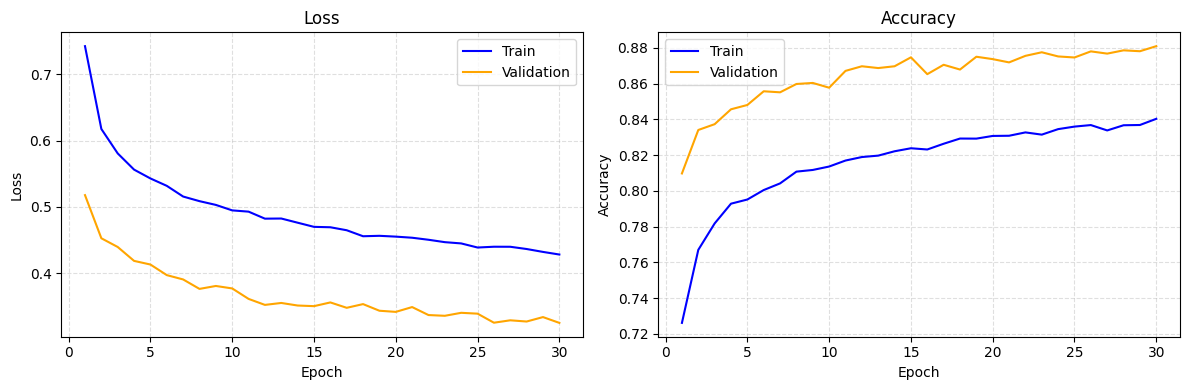

In [124]:
plot_train_val_curves(train_losses, val_losses, train_accs, val_accs)

In [125]:
test_loss, test_acc = evaluate(mlp_model, test_loader, criterion, device)

print(f"Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

Final Test Loss: 0.3361 | Final Test Acc: 0.8769


#### Linear Layer Findings

<div style="display:flex; gap:16px;">
  <img src="reports/linear/images/mlp-loss.png" width="48%">
  <img src="reports/linear/images/mlp-acc.png" width="48%">
</div>

Best Configuration: BatchNorm + Dropout `mlp_aug0_bn1_do1` (89.71% test accuracy)

- Combining BatchNorm and Dropout (0.4, 0.3) achieved the best test performance
- Lowest test loss (0.3109) indicates good generalization
- Training stabilized around epoch 5 and maintained steady improvement

Regularization Effects:

- Dropout is essential - Without dropout, models overfit significantly (test loss jumps to 0.49-0.55 despite reasonable accuracy)
- BatchNorm helps but isn't sufficient alone - BN without dropout still overfits (loss 0.4951)


The best performing configuration was BatchNorm + Dropout without augmentation, reaching 89.71% test accuracy.\
 Augmentation significantly harmed the MLP due to the model’s lack of spatial invariance, confirming that geometric augmentations are better suited for convolution-based architectures.

### Convolutional Neural Nets

In [126]:
class SimpleCNN(nn.Module):
    def __init__(self, use_dropout_2d=False, use_dropout=True, use_batchnorm=True):
        super(SimpleCNN, self).__init__()

        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.use_dropout_2d = use_dropout_2d

        # (b, c, h, w)
        # In:       (128, 1, 28, 28)
        # Out:      (128, 32, 28, 28)
        # Pooled:   (128, 32, 14, 14)
        self.conv_1 = nn.Conv2d(1, 32, 3, stride=1, padding=1)
        self.conv_2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        self.conv_3 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.conv_4 = nn.Conv2d(128, 256, 3, stride=1, padding=1)

        self.max_pool = nn.MaxPool2d(2, 2)

        if self.use_batchnorm:
            self.bn_1 = nn.BatchNorm2d(32)
            self.bn_2 = nn.BatchNorm2d(64)
            self.bn_3 = nn.BatchNorm2d(128)
            self.bn_4 = nn.BatchNorm2d(256)
            self.bn_5 = nn.BatchNorm1d(128)
            self.bn_6 = nn.BatchNorm1d(64)

        if self.use_dropout_2d:
            self.drop2d_1 = nn.Dropout2d(0.1)
            self.drop2d_2 = nn.Dropout2d(0.1)
            self.drop2d_3 = nn.Dropout2d(0.1)
            self.drop2d_4 = nn.Dropout2d(0.1)

        self.act = nn.ReLU()

        # (128, 256, 1, 1)
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        self.linear_1 = nn.Linear(256, 128, True)
        self.linear_2 = nn.Linear(128, 64, True)
        self.linear_3 = nn.Linear(64, 10)

        if self.use_dropout:
            self.drop_1 = nn.Dropout(0.3)
            self.drop_2 = nn.Dropout(0.2)

    def forward(self, x):
        x = self.conv_1(x)
        if self.use_batchnorm:
            x = self.bn_1(x)
        x = self.act(x)
        x = self.max_pool(x)
        if self.use_dropout_2d:
            x = self.drop2d_1(x)

        x = self.conv_2(x)
        if self.use_batchnorm:
            x = self.bn_2(x)
        x = self.act(x)
        if self.use_dropout_2d:
            x = self.drop2d_2(x)

        x = self.conv_3(x)
        if self.use_batchnorm:
            x = self.bn_3(x)
        x = self.act(x)
        if self.use_dropout_2d:
            x = self.drop2d_3(x)

        x = self.conv_4(x)
        if self.use_batchnorm:
            x = self.bn_4(x)
        x = self.act(x)
        if self.use_dropout_2d:
            x = self.drop2d_4(x)

        x = self.gap(x)
        x = x.view(x.size(0), -1)

        x = self.linear_1(x)
        if self.use_batchnorm:
            x = self.bn_5(x)
        x = self.act(x)
        if self.use_dropout:
            x = self.drop_1(x)

        x = self.linear_2(x)
        if self.use_batchnorm:
            x = self.bn_6(x)
        x = self.act(x)
        if self.use_dropout:
            x = self.drop_2(x)

        x = self.linear_3(x)

        return x

Hyperparams

In [127]:
learning_rate = 0.001
epochs = 30

In [128]:
cnn_model = SimpleCNN(False, False, True).to(device)
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=learning_rate)
criterion = torch.nn.CrossEntropyLoss()

In [129]:
writer = SummaryWriter(log_dir="cnn_logs/cnn_aug1_bn1_do0")

In [130]:
summary(cnn_model)

Layer (type:depth-idx)                   Param #
SimpleCNN                                --
├─Conv2d: 1-1                            320
├─Conv2d: 1-2                            18,496
├─Conv2d: 1-3                            73,856
├─Conv2d: 1-4                            295,168
├─MaxPool2d: 1-5                         --
├─BatchNorm2d: 1-6                       64
├─BatchNorm2d: 1-7                       128
├─BatchNorm2d: 1-8                       256
├─BatchNorm2d: 1-9                       512
├─BatchNorm1d: 1-10                      256
├─BatchNorm1d: 1-11                      128
├─ReLU: 1-12                             --
├─AdaptiveAvgPool2d: 1-13                --
├─Linear: 1-14                           32,896
├─Linear: 1-15                           8,256
├─Linear: 1-16                           650
Total params: 430,986
Trainable params: 430,986
Non-trainable params: 0

In [131]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for epoch in tqdm(range(epochs)):
    cnn_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_accuracy = evaluate(cnn_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_accuracy)

    writer.add_scalar("train/loss", train_loss, epoch)
    writer.add_scalar("train/accuracy", train_acc, epoch)
    writer.add_scalar("val/loss", val_loss, epoch)
    writer.add_scalar("val/accuracy", val_accuracy, epoch)

    print(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f}"
    )

writer.close()

  3%|▎         | 1/30 [00:32<15:42, 32.49s/it]

Epoch [1/30] Train Loss: 0.6413 Acc: 0.7846 | Val Loss: 0.4545 Acc: 0.8366


  7%|▋         | 2/30 [01:04<15:02, 32.23s/it]

Epoch [2/30] Train Loss: 0.4132 Acc: 0.8483 | Val Loss: 0.5136 Acc: 0.8177


 10%|█         | 3/30 [01:37<14:33, 32.37s/it]

Epoch [3/30] Train Loss: 0.3610 Acc: 0.8660 | Val Loss: 0.3825 Acc: 0.8635


 13%|█▎        | 4/30 [02:09<14:06, 32.54s/it]

Epoch [4/30] Train Loss: 0.3359 Acc: 0.8759 | Val Loss: 0.3903 Acc: 0.8569


 17%|█▋        | 5/30 [02:43<13:44, 32.99s/it]

Epoch [5/30] Train Loss: 0.3209 Acc: 0.8816 | Val Loss: 0.2805 Acc: 0.8963


 20%|██        | 6/30 [03:15<13:05, 32.73s/it]

Epoch [6/30] Train Loss: 0.3002 Acc: 0.8889 | Val Loss: 0.2730 Acc: 0.9018


 23%|██▎       | 7/30 [03:47<12:28, 32.52s/it]

Epoch [7/30] Train Loss: 0.2916 Acc: 0.8922 | Val Loss: 0.3168 Acc: 0.8849


 27%|██▋       | 8/30 [04:20<11:52, 32.41s/it]

Epoch [8/30] Train Loss: 0.2788 Acc: 0.8969 | Val Loss: 0.2650 Acc: 0.9032


 30%|███       | 9/30 [04:53<11:25, 32.66s/it]

Epoch [9/30] Train Loss: 0.2682 Acc: 0.8999 | Val Loss: 0.2744 Acc: 0.9036


 33%|███▎      | 10/30 [05:29<11:13, 33.68s/it]

Epoch [10/30] Train Loss: 0.2632 Acc: 0.9030 | Val Loss: 0.2469 Acc: 0.9083


 37%|███▋      | 11/30 [06:07<11:04, 34.96s/it]

Epoch [11/30] Train Loss: 0.2566 Acc: 0.9045 | Val Loss: 0.2668 Acc: 0.9025


 40%|████      | 12/30 [06:52<11:24, 38.02s/it]

Epoch [12/30] Train Loss: 0.2487 Acc: 0.9077 | Val Loss: 0.2668 Acc: 0.9013


 43%|████▎     | 13/30 [07:32<10:58, 38.74s/it]

Epoch [13/30] Train Loss: 0.2474 Acc: 0.9081 | Val Loss: 0.2358 Acc: 0.9130


 47%|████▋     | 14/30 [08:09<10:08, 38.05s/it]

Epoch [14/30] Train Loss: 0.2402 Acc: 0.9100 | Val Loss: 0.2200 Acc: 0.9218


 50%|█████     | 15/30 [08:46<09:26, 37.77s/it]

Epoch [15/30] Train Loss: 0.2321 Acc: 0.9134 | Val Loss: 0.2255 Acc: 0.9183


 53%|█████▎    | 16/30 [09:22<08:43, 37.36s/it]

Epoch [16/30] Train Loss: 0.2309 Acc: 0.9151 | Val Loss: 0.2260 Acc: 0.9163


 57%|█████▋    | 17/30 [09:58<08:01, 37.02s/it]

Epoch [17/30] Train Loss: 0.2232 Acc: 0.9174 | Val Loss: 0.2370 Acc: 0.9161


 60%|██████    | 18/30 [10:35<07:21, 36.77s/it]

Epoch [18/30] Train Loss: 0.2254 Acc: 0.9160 | Val Loss: 0.2402 Acc: 0.9143


 63%|██████▎   | 19/30 [11:11<06:42, 36.61s/it]

Epoch [19/30] Train Loss: 0.2160 Acc: 0.9198 | Val Loss: 0.2368 Acc: 0.9148


 67%|██████▋   | 20/30 [11:47<06:04, 36.47s/it]

Epoch [20/30] Train Loss: 0.2149 Acc: 0.9220 | Val Loss: 0.2189 Acc: 0.9193


 70%|███████   | 21/30 [12:23<05:27, 36.39s/it]

Epoch [21/30] Train Loss: 0.2105 Acc: 0.9229 | Val Loss: 0.2052 Acc: 0.9260


 73%|███████▎  | 22/30 [13:00<04:52, 36.58s/it]

Epoch [22/30] Train Loss: 0.2078 Acc: 0.9234 | Val Loss: 0.2073 Acc: 0.9243


 77%|███████▋  | 23/30 [13:37<04:16, 36.61s/it]

Epoch [23/30] Train Loss: 0.2008 Acc: 0.9265 | Val Loss: 0.2592 Acc: 0.9051


 80%|████████  | 24/30 [14:13<03:38, 36.48s/it]

Epoch [24/30] Train Loss: 0.2042 Acc: 0.9253 | Val Loss: 0.2040 Acc: 0.9253


 83%|████████▎ | 25/30 [14:49<03:01, 36.29s/it]

Epoch [25/30] Train Loss: 0.1985 Acc: 0.9258 | Val Loss: 0.2183 Acc: 0.9217


 87%|████████▋ | 26/30 [15:25<02:24, 36.21s/it]

Epoch [26/30] Train Loss: 0.1960 Acc: 0.9272 | Val Loss: 0.1914 Acc: 0.9304


 90%|█████████ | 27/30 [16:00<01:47, 35.98s/it]

Epoch [27/30] Train Loss: 0.1922 Acc: 0.9282 | Val Loss: 0.2081 Acc: 0.9246


 93%|█████████▎| 28/30 [16:35<01:11, 35.58s/it]

Epoch [28/30] Train Loss: 0.1907 Acc: 0.9285 | Val Loss: 0.2078 Acc: 0.9242


 97%|█████████▋| 29/30 [17:09<00:35, 35.20s/it]

Epoch [29/30] Train Loss: 0.1854 Acc: 0.9314 | Val Loss: 0.1992 Acc: 0.9312


100%|██████████| 30/30 [17:44<00:00, 35.49s/it]

Epoch [30/30] Train Loss: 0.1859 Acc: 0.9297 | Val Loss: 0.2061 Acc: 0.9274


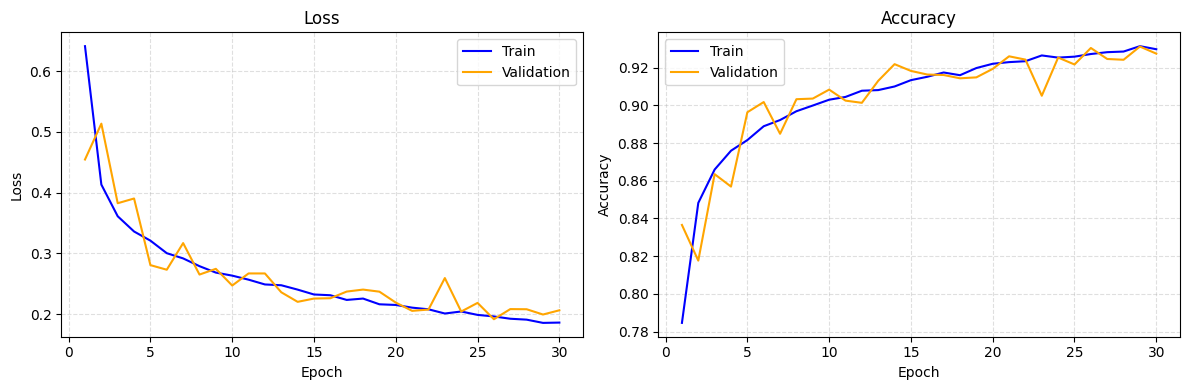

In [132]:
plot_train_val_curves(train_losses, val_losses, train_accs, val_accs)

In [152]:
test_loss, test_acc = evaluate(cnn_model, test_loader, criterion, device)

print(f"Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

# cnn_aug1_bn1_do1 => Final Test Loss: 0.2231 | Final Test Acc: 0.9222

Final Test Loss: 0.8255 | Final Test Acc: 0.9222


#### VGG Like Architecture 

In [153]:
import torch
import torch.nn as nn


class VGGLikeNet(nn.Module):
    def __init__(
        self, use_dropout_2d=False, use_dropout=True, use_batchnorm=True, strided=False
    ):
        super(VGGLikeNet, self).__init__()

        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout
        self.use_dropout_2d = use_dropout_2d
        self.strided = strided

        # 28x28 -> 14x14
        # width 32
        block1_layers = [
            nn.Conv2d(1, 32, 3, padding=1, stride=2 if strided else 1),
            nn.BatchNorm2d(32) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
        ]

        if not strided:
            block1_layers += [
                nn.MaxPool2d(2, 2),
            ]

        block1_layers += [
            nn.Dropout2d(0.1) if use_dropout_2d else nn.Identity(),
        ]

        self.block1 = nn.Sequential(*block1_layers)

        # 14x14 -> 7x7
        # width 64
        block2_layers = [
            nn.Conv2d(32, 64, 3, padding=1, stride=2 if strided else 1),
            nn.BatchNorm2d(64) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),  # Extra conv
            nn.BatchNorm2d(64) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
        ]

        if not strided:
            block2_layers += [
                nn.MaxPool2d(2, 2),
            ]

        block2_layers += [
            nn.Dropout2d(0.1) if use_dropout_2d else nn.Identity(),
        ]

        self.block2 = nn.Sequential(*block2_layers)

        # 7x7 -> 3x3 (maxpool) or 7x7 -> 4x4 (strided conv)
        # width 128
        block3_layers = [
            nn.Conv2d(64, 128, 3, padding=1, stride=2 if strided else 1),
            nn.BatchNorm2d(128) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),  # Extra conv
            nn.BatchNorm2d(128) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
        ]

        if not strided:
            block3_layers += [
                nn.MaxPool2d(2, 2),
            ]

        block3_layers += [
            nn.Dropout2d(0.1) if use_dropout_2d else nn.Identity(),
        ]

        self.block3 = nn.Sequential(*block3_layers)

        # will Adapt kernel -> 1x1
        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        #  128 -> 64 -> 10
        classifier_layers = [
            nn.Flatten(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3) if use_dropout else nn.Identity(),
            nn.Linear(64, 10),
        ]
        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

Hyperparams

In [154]:
learning_rate = 0.001
epochs = 30

In [ ]:
vgg_like_model = VGGLikeNet(
    use_dropout_2d=True, use_dropout=False, use_batchnorm=True, strided=False
).to(device)

optimizer = torch.optim.AdamW(vgg_like_model.parameters(), lr=0.001, weight_decay=1e-2)

# cosine shape - max 0.003 lr for faster convergence with low epochs
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-3,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    anneal_strategy="cos",
)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.05)

In [ ]:
writer = SummaryWriter(
    log_dir="cnn_logs/vgg_aug1_bn1_do1_strided_scheduled_smoothed_e30"
)

In [157]:
summary(vgg_like_model)

Layer (type:depth-idx)                   Param #
VGGLikeNet                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       320
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─Conv2d: 2-4                       9,248
│    └─BatchNorm2d: 2-5                  64
│    └─ReLU: 2-6                         --
│    └─Dropout2d: 2-7                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-8                       18,496
│    └─BatchNorm2d: 2-9                  128
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      36,928
│    └─BatchNorm2d: 2-12                 128
│    └─ReLU: 2-13                        --
│    └─Conv2d: 2-14                      36,928
│    └─BatchNorm2d: 2-15                 128
│    └─ReLU: 2-16                        --
│    └─Dropout2d: 2-17                   --
├─Sequential: 1-3                        --
│    └─C

In [158]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
lrs = []

for epoch in tqdm(range(epochs)):
    vgg_like_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg_like_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_accuracy = evaluate(vgg_like_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_accuracy)

    writer.add_scalar("train/loss", train_loss, epoch)
    writer.add_scalar("train/accuracy", train_acc, epoch)
    writer.add_scalar("val/loss", val_loss, epoch)
    writer.add_scalar("val/accuracy", val_accuracy, epoch)
    writer.add_scalar("lr", lrs[-1], epoch)  # log LR each epoch

    print(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f} | "
        f"LR: {lrs[-1]:.6f}"
    )

writer.close()

  3%|▎         | 1/30 [00:17<08:16, 17.11s/it]

Epoch [1/30] Train Loss: 1.2240 Acc: 0.6634 | Val Loss: 0.7471 Acc: 0.8100 | LR: 0.000313


  7%|▋         | 2/30 [00:32<07:28, 16.03s/it]

Epoch [2/30] Train Loss: 0.7678 Acc: 0.7984 | Val Loss: 0.6599 Acc: 0.8431 | LR: 0.000841


 10%|█         | 3/30 [00:47<07:05, 15.75s/it]

Epoch [3/30] Train Loss: 0.6876 Acc: 0.8302 | Val Loss: 0.6099 Acc: 0.8628 | LR: 0.001561


 13%|█▎        | 4/30 [01:02<06:41, 15.43s/it]

Epoch [4/30] Train Loss: 0.6524 Acc: 0.8452 | Val Loss: 0.5523 Acc: 0.8881 | LR: 0.002281


 17%|█▋        | 5/30 [01:17<06:18, 15.13s/it]

Epoch [5/30] Train Loss: 0.6219 Acc: 0.8593 | Val Loss: 0.5774 Acc: 0.8721 | LR: 0.002808


 20%|██        | 6/30 [01:32<06:00, 15.01s/it]

Epoch [6/30] Train Loss: 0.6034 Acc: 0.8657 | Val Loss: 0.5426 Acc: 0.8894 | LR: 0.003000


 23%|██▎       | 7/30 [01:46<05:39, 14.78s/it]

Epoch [7/30] Train Loss: 0.5874 Acc: 0.8698 | Val Loss: 0.5451 Acc: 0.8899 | LR: 0.002987


 27%|██▋       | 8/30 [02:01<05:28, 14.93s/it]

Epoch [8/30] Train Loss: 0.5730 Acc: 0.8786 | Val Loss: 0.5114 Acc: 0.9038 | LR: 0.002949


 30%|███       | 9/30 [02:16<05:10, 14.77s/it]

Epoch [9/30] Train Loss: 0.5615 Acc: 0.8834 | Val Loss: 0.5172 Acc: 0.8999 | LR: 0.002886


 33%|███▎      | 10/30 [02:31<04:57, 14.90s/it]

Epoch [10/30] Train Loss: 0.5546 Acc: 0.8879 | Val Loss: 0.5187 Acc: 0.9016 | LR: 0.002799


 37%|███▋      | 11/30 [02:46<04:42, 14.89s/it]

Epoch [11/30] Train Loss: 0.5471 Acc: 0.8885 | Val Loss: 0.5108 Acc: 0.9047 | LR: 0.002690


 40%|████      | 12/30 [03:00<04:25, 14.75s/it]

Epoch [12/30] Train Loss: 0.5392 Acc: 0.8920 | Val Loss: 0.4951 Acc: 0.9111 | LR: 0.002560


 43%|████▎     | 13/30 [03:15<04:09, 14.70s/it]

Epoch [13/30] Train Loss: 0.5330 Acc: 0.8949 | Val Loss: 0.5087 Acc: 0.9025 | LR: 0.002413


 47%|████▋     | 14/30 [03:29<03:53, 14.58s/it]

Epoch [14/30] Train Loss: 0.5249 Acc: 0.8994 | Val Loss: 0.4766 Acc: 0.9194 | LR: 0.002250


 50%|█████     | 15/30 [03:43<03:37, 14.53s/it]

Epoch [15/30] Train Loss: 0.5196 Acc: 0.9002 | Val Loss: 0.4761 Acc: 0.9205 | LR: 0.002074


 53%|█████▎    | 16/30 [03:58<03:22, 14.47s/it]

Epoch [16/30] Train Loss: 0.5107 Acc: 0.9032 | Val Loss: 0.4708 Acc: 0.9214 | LR: 0.001888


 57%|█████▋    | 17/30 [04:12<03:08, 14.52s/it]

Epoch [17/30] Train Loss: 0.5049 Acc: 0.9060 | Val Loss: 0.4659 Acc: 0.9214 | LR: 0.001695


 60%|██████    | 18/30 [04:27<02:54, 14.54s/it]

Epoch [18/30] Train Loss: 0.4978 Acc: 0.9096 | Val Loss: 0.4669 Acc: 0.9229 | LR: 0.001499


 63%|██████▎   | 19/30 [04:41<02:39, 14.48s/it]

Epoch [19/30] Train Loss: 0.4938 Acc: 0.9116 | Val Loss: 0.4568 Acc: 0.9263 | LR: 0.001304


 67%|██████▋   | 20/30 [04:56<02:24, 14.48s/it]

Epoch [20/30] Train Loss: 0.4830 Acc: 0.9163 | Val Loss: 0.4563 Acc: 0.9267 | LR: 0.001111


 70%|███████   | 21/30 [05:10<02:10, 14.52s/it]

Epoch [21/30] Train Loss: 0.4751 Acc: 0.9197 | Val Loss: 0.4599 Acc: 0.9273 | LR: 0.000925


 73%|███████▎  | 22/30 [05:26<01:59, 14.93s/it]

Epoch [22/30] Train Loss: 0.4731 Acc: 0.9206 | Val Loss: 0.4515 Acc: 0.9298 | LR: 0.000750


 77%|███████▋  | 23/30 [05:42<01:46, 15.16s/it]

Epoch [23/30] Train Loss: 0.4664 Acc: 0.9234 | Val Loss: 0.4502 Acc: 0.9288 | LR: 0.000586


 80%|████████  | 24/30 [05:57<01:31, 15.25s/it]

Epoch [24/30] Train Loss: 0.4590 Acc: 0.9272 | Val Loss: 0.4546 Acc: 0.9270 | LR: 0.000439


 83%|████████▎ | 25/30 [06:13<01:16, 15.35s/it]

Epoch [25/30] Train Loss: 0.4550 Acc: 0.9297 | Val Loss: 0.4436 Acc: 0.9344 | LR: 0.000310


 87%|████████▋ | 26/30 [06:28<01:00, 15.25s/it]

Epoch [26/30] Train Loss: 0.4505 Acc: 0.9308 | Val Loss: 0.4430 Acc: 0.9336 | LR: 0.000201


 90%|█████████ | 27/30 [06:44<00:46, 15.36s/it]

Epoch [27/30] Train Loss: 0.4469 Acc: 0.9316 | Val Loss: 0.4392 Acc: 0.9345 | LR: 0.000114


 93%|█████████▎| 28/30 [06:59<00:30, 15.46s/it]

Epoch [28/30] Train Loss: 0.4452 Acc: 0.9325 | Val Loss: 0.4382 Acc: 0.9350 | LR: 0.000051


 97%|█████████▋| 29/30 [07:14<00:15, 15.28s/it]

Epoch [29/30] Train Loss: 0.4430 Acc: 0.9332 | Val Loss: 0.4378 Acc: 0.9347 | LR: 0.000013


100%|██████████| 30/30 [07:29<00:00, 14.98s/it]

Epoch [30/30] Train Loss: 0.4434 Acc: 0.9323 | Val Loss: 0.4378 Acc: 0.9349 | LR: 0.000000


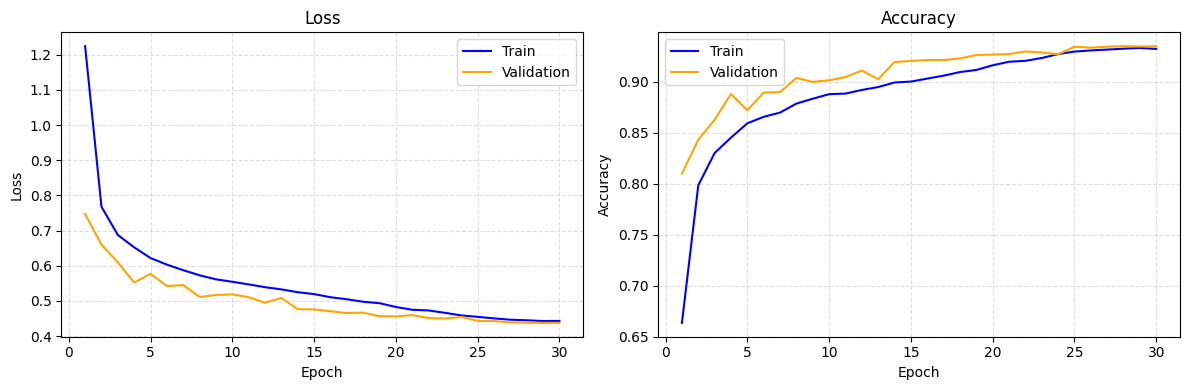

In [159]:
plot_train_val_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
test_loss, test_acc = evaluate(vgg_like_model, test_loader, criterion, device)

print(f"Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

# vgg_aug1_bn1_do1 => Final Test Loss: 0.2157 | Final Test Acc: 0.9218 (struggling to converge)
# vgg_aug1_bn1_do0 => Final Test Loss: 0.1839 | Final Test Acc: 0.9358 (need more epcohes to converge)
# vgg_aug1_bn1_do0_e50 => Final Test Loss: 0.2110 | Final Test Acc: 0.9271 (healthy but lower accuracy)
# vgg_aug1_bn1_do1_scheduled_smoothed_e30 => Final Test Loss: 0.4224 | Final Test Acc: 0.9428
# vgg_aug1_bn1_do1_strided_scheduled_smoothed_e30 => Final Test Loss: 0.4441 | Final Test Acc: 0.9326

Final Test Loss: 0.4441 | Final Test Acc: 0.9326


### Residual Connections | Resnet Like

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, use_batchnorm=True):
        super().__init__()

        self.use_batchnorm = use_batchnorm

        self.conv_1 = nn.Conv2d(
            in_channels, out_channels, 3, stride, padding=1, bias=False
        )
        self.bn1 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()
        self.relu = nn.ReLU()

        self.conv_2 = nn.Conv2d(out_channels, out_channels, 3, 1, padding=1, bias=False)

        self.bn2 = nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity()

        # skip connection - residual
        if stride != 1 or in_channels != out_channels:
            # 1x1 convolution to get the same tensor shape
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, 1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels) if use_batchnorm else nn.Identity(),
            )
        else:
            self.skip = nn.Identity()

    def forward(self, x):
        identity = self.skip(x)

        out = self.conv_1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv_2(out)
        out = self.bn2(out)

        out = out + identity
        out = self.relu(out)

        return out

In [ ]:
class ResidualNet(nn.Module):
    def __init__(self, use_batchnorm=True, use_dropout=False):
        super().__init__()

        self.use_batchnorm = use_batchnorm
        self.use_dropout = use_dropout

        # stem: 28x28 -> 28x28
        stem_layers = [
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32) if use_batchnorm else nn.Identity(),
            nn.ReLU(inplace=True),
        ]
        self.stem = nn.Sequential(*stem_layers)

        # residual blocks
        # 28x28 -> 28x28
        # (convolution convolution + skip) (convolution, convolution + skip)
        self.block1 = nn.Sequential(
            ResidualBlock(32, 32, stride=1, use_batchnorm=use_batchnorm),
            ResidualBlock(32, 32, stride=1, use_batchnorm=use_batchnorm),
        )

        # 28x28 -> 14x14
        self.block2 = nn.Sequential(
            ResidualBlock(32, 64, stride=2, use_batchnorm=use_batchnorm),
            ResidualBlock(64, 64, stride=1, use_batchnorm=use_batchnorm),
        )

        # 14x14 -> 7x7
        self.block3 = nn.Sequential(
            ResidualBlock(64, 128, stride=2, use_batchnorm=use_batchnorm),
            ResidualBlock(128, 128, stride=1, use_batchnorm=use_batchnorm),
            ResidualBlock(128, 128, stride=1, use_batchnorm=use_batchnorm),
        )

        # 7x7 -> 7x7
        self.block4 = nn.Sequential(
            ResidualBlock(128, 128, stride=1, use_batchnorm=use_batchnorm),
        )

        self.gap = nn.AdaptiveAvgPool2d((1, 1))

        classifier_layers = [
            nn.Flatten(),
        ]

        if use_dropout:
            classifier_layers += [nn.Dropout(0.1)]

        classifier_layers += [
            nn.Linear(128, 10),
        ]

        self.classifier = nn.Sequential(*classifier_layers)

    def forward(self, x):
        x = self.stem(x)
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.block4(x)
        x = self.gap(x)
        x = self.classifier(x)
        return x

Hyperparams

In [35]:
learning_rate = 0.001
epochs = 40

In [36]:
resnet_like_model = ResidualNet(use_batchnorm=True, use_dropout=True).to(device)

optimizer = torch.optim.AdamW(
    resnet_like_model.parameters(), lr=0.001, weight_decay=1e-2
)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-3,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    anneal_strategy="cos",
)

criterion = torch.nn.CrossEntropyLoss(label_smoothing=0.02)

In [ ]:
writer = SummaryWriter(log_dir="cnn_logs/residual_aug1_bn1_do1_scheduled_smoothed_e40")

In [38]:
summary(resnet_like_model)

Layer (type:depth-idx)                   Param #
ResidualNet                              --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       288
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
├─Sequential: 1-2                        --
│    └─ResidualBlock: 2-4                --
│    │    └─Conv2d: 3-1                  9,216
│    │    └─BatchNorm2d: 3-2             64
│    │    └─ReLU: 3-3                    --
│    │    └─Conv2d: 3-4                  9,216
│    │    └─BatchNorm2d: 3-5             64
│    │    └─Identity: 3-6                --
│    └─ResidualBlock: 2-5                --
│    │    └─Conv2d: 3-7                  9,216
│    │    └─BatchNorm2d: 3-8             64
│    │    └─ReLU: 3-9                    --
│    │    └─Conv2d: 3-10                 9,216
│    │    └─BatchNorm2d: 3-11            64
│    │    └─Identity: 3-12               --
├─Sequential: 1-3                        --
│    └─Residua

In [39]:
train_losses = []
val_losses = []
train_accs = []
val_accs = []
lrs = []

for epoch in tqdm(range(epochs)):
    resnet_like_model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet_like_model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        scheduler.step()
        lrs.append(scheduler.get_last_lr()[0])

        running_loss += loss.item() * labels.size(0)
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / total
    train_acc = correct / total

    val_loss, val_accuracy = evaluate(resnet_like_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_accuracy)

    writer.add_scalar("train/loss", train_loss, epoch)
    writer.add_scalar("train/accuracy", train_acc, epoch)
    writer.add_scalar("val/loss", val_loss, epoch)
    writer.add_scalar("val/accuracy", val_accuracy, epoch)
    writer.add_scalar("lr", lrs[-1], epoch)  # log LR each epoch

    print(
        f"Epoch [{epoch + 1}/{epochs}] "
        f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
        f"Val Loss: {val_loss:.4f} Acc: {val_accuracy:.4f} | "
        f"LR: {lrs[-1]:.6f}"
    )

writer.close()

  2%|▎         | 1/40 [00:55<35:51, 55.18s/it]

Epoch [1/40] Train Loss: 0.7875 Acc: 0.7404 | Val Loss: 0.5685 Acc: 0.8345 | LR: 0.000230


  5%|▌         | 2/40 [01:49<34:26, 54.39s/it]

Epoch [2/40] Train Loss: 0.5473 Acc: 0.8406 | Val Loss: 0.4938 Acc: 0.8608 | LR: 0.000542


  8%|▊         | 3/40 [02:42<33:21, 54.10s/it]

Epoch [3/40] Train Loss: 0.5024 Acc: 0.8578 | Val Loss: 0.4445 Acc: 0.8828 | LR: 0.001009


 10%|█         | 4/40 [03:36<32:22, 53.97s/it]

Epoch [4/40] Train Loss: 0.4719 Acc: 0.8710 | Val Loss: 0.4254 Acc: 0.8922 | LR: 0.001561


 12%|█▎        | 5/40 [04:30<31:26, 53.90s/it]

Epoch [5/40] Train Loss: 0.4474 Acc: 0.8796 | Val Loss: 0.3832 Acc: 0.9042 | LR: 0.002112


 15%|█▌        | 6/40 [05:24<30:32, 53.90s/it]

Epoch [6/40] Train Loss: 0.4324 Acc: 0.8856 | Val Loss: 0.3828 Acc: 0.9063 | LR: 0.002579


 18%|█▊        | 7/40 [06:18<29:37, 53.87s/it]

Epoch [7/40] Train Loss: 0.4151 Acc: 0.8913 | Val Loss: 0.4915 Acc: 0.8843 | LR: 0.002891


 20%|██        | 8/40 [07:11<28:42, 53.84s/it]

Epoch [8/40] Train Loss: 0.3981 Acc: 0.8979 | Val Loss: 0.3957 Acc: 0.9033 | LR: 0.003000


 22%|██▎       | 9/40 [08:05<27:49, 53.86s/it]

Epoch [9/40] Train Loss: 0.3834 Acc: 0.9032 | Val Loss: 0.3980 Acc: 0.8972 | LR: 0.002993


 25%|██▌       | 10/40 [08:59<26:56, 53.87s/it]

Epoch [10/40] Train Loss: 0.3758 Acc: 0.9070 | Val Loss: 0.3436 Acc: 0.9184 | LR: 0.002971


 28%|██▊       | 11/40 [09:53<26:02, 53.89s/it]

Epoch [11/40] Train Loss: 0.3696 Acc: 0.9094 | Val Loss: 0.3585 Acc: 0.9137 | LR: 0.002935


 30%|███       | 12/40 [10:47<25:09, 53.90s/it]

Epoch [12/40] Train Loss: 0.3627 Acc: 0.9125 | Val Loss: 0.3310 Acc: 0.9227 | LR: 0.002886


 32%|███▎      | 13/40 [11:41<24:14, 53.88s/it]

Epoch [13/40] Train Loss: 0.3526 Acc: 0.9150 | Val Loss: 0.3366 Acc: 0.9220 | LR: 0.002823


 35%|███▌      | 14/40 [12:40<24:02, 55.49s/it]

Epoch [14/40] Train Loss: 0.3418 Acc: 0.9208 | Val Loss: 0.3509 Acc: 0.9172 | LR: 0.002747


 38%|███▊      | 15/40 [13:40<23:42, 56.90s/it]

Epoch [15/40] Train Loss: 0.3399 Acc: 0.9208 | Val Loss: 0.3592 Acc: 0.9114 | LR: 0.002659


 40%|████      | 16/40 [14:39<23:02, 57.58s/it]

Epoch [16/40] Train Loss: 0.3334 Acc: 0.9226 | Val Loss: 0.3773 Acc: 0.9093 | LR: 0.002560


 42%|████▎     | 17/40 [15:38<22:11, 57.88s/it]

Epoch [17/40] Train Loss: 0.3287 Acc: 0.9256 | Val Loss: 0.3207 Acc: 0.9260 | LR: 0.002451


 45%|████▌     | 18/40 [16:36<21:15, 58.00s/it]

Epoch [18/40] Train Loss: 0.3246 Acc: 0.9276 | Val Loss: 0.3175 Acc: 0.9279 | LR: 0.002333


 48%|████▊     | 19/40 [17:35<20:22, 58.22s/it]

Epoch [19/40] Train Loss: 0.3147 Acc: 0.9304 | Val Loss: 0.3082 Acc: 0.9333 | LR: 0.002207


 50%|█████     | 20/40 [18:34<19:29, 58.49s/it]

Epoch [20/40] Train Loss: 0.3100 Acc: 0.9311 | Val Loss: 0.3095 Acc: 0.9330 | LR: 0.002074


 52%|█████▎    | 21/40 [19:32<18:30, 58.47s/it]

Epoch [21/40] Train Loss: 0.3022 Acc: 0.9343 | Val Loss: 0.3128 Acc: 0.9327 | LR: 0.001935


 55%|█████▌    | 22/40 [20:32<17:36, 58.70s/it]

Epoch [22/40] Train Loss: 0.2982 Acc: 0.9373 | Val Loss: 0.2962 Acc: 0.9355 | LR: 0.001792


 57%|█████▊    | 23/40 [21:31<16:42, 59.00s/it]

Epoch [23/40] Train Loss: 0.2927 Acc: 0.9383 | Val Loss: 0.2988 Acc: 0.9345 | LR: 0.001647


 60%|██████    | 24/40 [22:32<15:52, 59.55s/it]

Epoch [24/40] Train Loss: 0.2849 Acc: 0.9414 | Val Loss: 0.3043 Acc: 0.9354 | LR: 0.001500


 62%|██████▎   | 25/40 [23:32<14:55, 59.70s/it]

Epoch [25/40] Train Loss: 0.2769 Acc: 0.9448 | Val Loss: 0.2852 Acc: 0.9407 | LR: 0.001353


 65%|██████▌   | 26/40 [24:32<13:55, 59.69s/it]

Epoch [26/40] Train Loss: 0.2733 Acc: 0.9456 | Val Loss: 0.2852 Acc: 0.9397 | LR: 0.001207


 68%|██████▊   | 27/40 [25:34<13:06, 60.48s/it]

Epoch [27/40] Train Loss: 0.2656 Acc: 0.9489 | Val Loss: 0.2844 Acc: 0.9413 | LR: 0.001064


 70%|███████   | 28/40 [26:37<12:15, 61.29s/it]

Epoch [28/40] Train Loss: 0.2616 Acc: 0.9496 | Val Loss: 0.2769 Acc: 0.9454 | LR: 0.000926


 72%|███████▎  | 29/40 [27:44<11:32, 62.99s/it]

Epoch [29/40] Train Loss: 0.2544 Acc: 0.9536 | Val Loss: 0.2837 Acc: 0.9421 | LR: 0.000793


 75%|███████▌  | 30/40 [28:57<10:58, 65.85s/it]

Epoch [30/40] Train Loss: 0.2486 Acc: 0.9553 | Val Loss: 0.2742 Acc: 0.9453 | LR: 0.000666


 78%|███████▊  | 31/40 [30:04<09:57, 66.35s/it]

Epoch [31/40] Train Loss: 0.2436 Acc: 0.9567 | Val Loss: 0.2733 Acc: 0.9477 | LR: 0.000548


 80%|████████  | 32/40 [31:12<08:53, 66.66s/it]

Epoch [32/40] Train Loss: 0.2369 Acc: 0.9597 | Val Loss: 0.2717 Acc: 0.9467 | LR: 0.000439


 82%|████████▎ | 33/40 [32:20<07:48, 66.99s/it]

Epoch [33/40] Train Loss: 0.2325 Acc: 0.9622 | Val Loss: 0.2726 Acc: 0.9479 | LR: 0.000340


 85%|████████▌ | 34/40 [33:35<06:57, 69.65s/it]

Epoch [34/40] Train Loss: 0.2271 Acc: 0.9640 | Val Loss: 0.2713 Acc: 0.9479 | LR: 0.000253


 88%|████████▊ | 35/40 [34:47<05:51, 70.32s/it]

Epoch [35/40] Train Loss: 0.2213 Acc: 0.9666 | Val Loss: 0.2692 Acc: 0.9485 | LR: 0.000177


 90%|█████████ | 36/40 [35:53<04:36, 69.07s/it]

Epoch [36/40] Train Loss: 0.2204 Acc: 0.9667 | Val Loss: 0.2697 Acc: 0.9485 | LR: 0.000114


 92%|█████████▎| 37/40 [37:08<03:31, 70.63s/it]

Epoch [37/40] Train Loss: 0.2161 Acc: 0.9685 | Val Loss: 0.2709 Acc: 0.9486 | LR: 0.000064


 95%|█████████▌| 38/40 [38:11<02:16, 68.43s/it]

Epoch [38/40] Train Loss: 0.2132 Acc: 0.9696 | Val Loss: 0.2696 Acc: 0.9483 | LR: 0.000029


 98%|█████████▊| 39/40 [39:17<01:07, 67.65s/it]

Epoch [39/40] Train Loss: 0.2137 Acc: 0.9684 | Val Loss: 0.2696 Acc: 0.9493 | LR: 0.000007


100%|██████████| 40/40 [40:17<00:00, 60.45s/it]

Epoch [40/40] Train Loss: 0.2130 Acc: 0.9699 | Val Loss: 0.2698 Acc: 0.9488 | LR: 0.000000


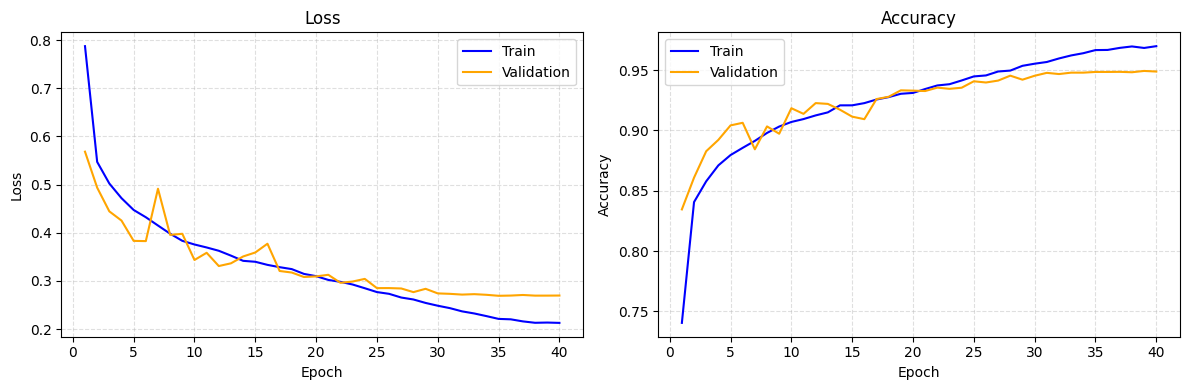

In [40]:
plot_train_val_curves(train_losses, val_losses, train_accs, val_accs)

In [ ]:
test_loss, test_acc = evaluate(resnet_like_model, test_loader, criterion, device)

print(f"Final Test Loss: {test_loss:.4f} | Final Test Acc: {test_acc:.4f}")

# residual_aug1_bn1_do0_scheduled_smoothed_e30 => Final Test Loss: 0.4092 | Final Test Acc: 0.9494
# residual_aug1_bn1_do1_scheduled_smoothed_e40 => Final Test Loss: 0.2732 | Final Test Acc: 0.9499

Final Test Loss: 0.2732 | Final Test Acc: 0.9499


#### CNN Findings

I have analysed the performance of three CNN architectures 
- VGG-like `red`
- ResNet-like `blue`
- Traditional CNN `green`

Trained on augmented image data and 30 epochs (Except final one - 40 epochs)

While ResNet architectures achieved the highest validation accuracy,\
the traditional CNN demonstrated competitive test performance despite using fewer training techniques.

<div style="display:flex; gap:16px;">
  <img src="reports/cnn/images/train-acc.png" width="48%">
  <img src="reports/cnn/images/val-acc.png" width="48%">
</div>
<div style="display:flex; gap:16px; margin-top:16px">
  <img src="reports/cnn/images/train-loss.png" width="48%">
  <img src="reports/cnn/images/val-loss.png" width="48%">
</div>

Data Augmentation Strategy:
- Random affine transformations (±10° rotation, 5% translation, 10% scaling, 5° shear)
- Horizontal flipping (20% probability)
- Random erasing (10% probability)
- Normalization (mean: 0.2860, std: 0.3530)

Training Techniques:
- ResNet & VGG: Learning rate scheduling + label smoothing
- CNN: No scheduling or smoothing applied

The performance gap between CNN (92.22%) and ResNet (94.99%) is notable given that CNN lacked learning rate scheduling and label smoothing.\
This 2.77% difference suggests these techniques contribute significantly to final performance,\
though the core architecture choice remains the dominant factor.

The `strided VGG` variant achieved respectable 93.26% accuracy in just 7.2 minutes,\
making it the most time-efficient option.\
However, the `ResNet (do0, e30)` offers the best accuracy-to-time ratio at 94.94% in 26.8 minutes.

<b>Importantly, all CNN-based architectures substantially outperformed the best MLP baseline (89.71% test accuracy)</b>\
Even the traditional CNN without learning rate scheduling or label smoothing achieved 92.22% accuracy, a 2.51 percentage point improvement over the MLP.